# **Código Grupo 8 - Trabajo Práctico N° 4 Clasificando pobres en la EPH: métodos de regularización y CART**

**Autores:**

Jorge Eduardo Bolaños Gamarra

Mario Antonio Valdivia Reyes

Hector Sebastian San Martin

In [ ]:
# =========================================================
# IMPORTAR LIBRERÍAS
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_curve,
                           roc_auc_score, accuracy_score, f1_score, precision_score,
                           recall_score, classification_report)
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive

# =========================================================
# CARGA Y PREPARACIÓN DE DATOS
# =========================================================

# Montar Google Drive
drive.mount('/content/drive')

# Definir ruta del archivo
path = "/content/drive/MyDrive/Taller de Programación - UBA/TP3/respondieron.xlsx"

# Cargar el dataset
df = pd.read_excel(path)

# Filtrar solo el año 2025
df = df[df['ANIO'] == 2025]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================================================
# PREPROCESAMIENTO
# =========================================================

# --- Encoding de estado civil CH07 ---
df["CH07"] = df["CH07"].replace(0, np.nan)
df_dummies = pd.get_dummies(df["CH07"], prefix="CH07", drop_first=True)
df_dummies = df_dummies.rename(columns={
    "CH07_1": "Unido",
    "CH07_2": "Casado",
    "CH07_3": "SeparadoDivorciado",
    "CH07_4": "Viudo",
    "CH07_5": "Soltero"
})
df = pd.concat([df, df_dummies], axis=1)

# --- Transformar CH06 (edad) ---
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df["CH06_yeojohnson"] = pt.fit_transform(df[["CH06"]])
scaler = StandardScaler()
df["CH06_scaled"] = scaler.fit_transform(df[["CH06_yeojohnson"]])
df["CH06_scaled_sq"] = df["CH06_scaled"] ** 2

# --- Transformar NIVEL_ED ---
df["NIVEL_ED"] = df["NIVEL_ED"].replace({9: np.nan})

# --- Variable binaria horas trabajadas ---
df["HORASTRAB_fulltime"] = np.where(df["HORASTRAB"] >= 40, 1, 0)

# --- Variable categórica educación ---
bins = [-1, 0, 5, 8, 11, 13, 16, 30]
labels = ["Sin_instruccion", "Primaria_incompleta", "Primaria_completa",
          "Secundaria_incompleta", "Secundaria_completa", "Superior_incompleto",
          "Superior_completo_Postgrado"]
df["AEDUC_cat"] = pd.cut(df["AEDUC"], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=["AEDUC_cat"], drop_first=True)


In [ ]:
# =========================================================
# PREPARACIÓN VARIABLES MODELO
# =========================================================

# Selección de variables independientes
var_X = [
    "CH04", "CH06_scaled", "HORASTRAB_fulltime",
    "Casado", "SeparadoDivorciado", "Viudo",
    'AEDUC_cat_Primaria_incompleta', 'AEDUC_cat_Primaria_completa',
    'AEDUC_cat_Secundaria_incompleta', 'AEDUC_cat_Secundaria_completa',
    'AEDUC_cat_Superior_incompleto', 'AEDUC_cat_Superior_completo_Postgrado'
]

# Definir X e y
X = df[var_X].copy()
y = df['POBRE']

# Limpiar datos faltantes
df_clean = pd.concat([X, y], axis=1).dropna()
X_clean = df_clean[X.columns]
y_clean = df_clean[y.name]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
)

In [ ]:
# =========================================================
# MODELOS DE REGRESIÓN LOGÍSTICA
# =========================================================

# Definir rango de lambdas
lambdas = np.logspace(-4, 2, 10)
coefs_l1, coefs_l2 = [], []

# Calcular coeficientes para diferentes lambdas
for lam in lambdas:
    Cval = 1.0 / lam

    # L1 (LASSO)
    try:
        model_l1 = LogisticRegression(
            penalty='l1', C=Cval, solver='saga', max_iter=50000,
            tol=1e-5, random_state=0
        )
        model_l1.fit(X_train, y_train)
        coefs_l1.append(model_l1.coef_.ravel().copy())
    except:
        coefs_l1.append(np.full(X_train.shape[1], np.nan))

    # L2 (Ridge)
    model_l2 = LogisticRegression(
        penalty='l2', C=Cval, solver='lbfgs', max_iter=10000,
        tol=1e-5, random_state=0
    )
    model_l2.fit(X_train, y_train)
    coefs_l2.append(model_l2.coef_.ravel().copy())

coefs_l1 = np.array(coefs_l1)
coefs_l2 = np.array(coefs_l2)

# Encontrar lambda óptimo con CV
kf = KFold(n_splits=5, shuffle=True, random_state=0)
Cs = np.logspace(-4, 2, 10)

lr_cv_l2 = LogisticRegressionCV(
    Cs=Cs, cv=kf, penalty='l2', solver='lbfgs', scoring='accuracy',
    max_iter=10000, random_state=0, n_jobs=-1
)
lr_cv_l2.fit(X_train, y_train)

lr_cv_l1 = LogisticRegressionCV(
    Cs=Cs, cv=kf, penalty='l1', solver='saga', scoring='accuracy',
    max_iter=50000, random_state=0, n_jobs=-1, refit=True
)
lr_cv_l1.fit(X_train, y_train)

C_opt_l2, C_opt_l1 = lr_cv_l2.C_[0], lr_cv_l1.C_[0]
lambda_opt_l2, lambda_opt_l1 = 1.0 / C_opt_l2, 1.0 / C_opt_l1

# Entrenar modelos finales
model_none = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, random_state=0)
model_none.fit(X_train, y_train)

model_l1_cv = LogisticRegression(penalty='l1', C=C_opt_l1, solver='saga',
                                 max_iter=50000, random_state=0)
model_l1_cv.fit(X_train, y_train)

model_l2_cv = LogisticRegression(penalty='l2', C=C_opt_l2, solver='lbfgs',
                                 max_iter=10000, random_state=0)
model_l2_cv.fit(X_train, y_train)

# Guardar resultados en un diccionario
resultados_modelos = {
    'none': model_none,
    'l1': model_l1_cv,
    'l2': model_l2_cv,
    'coefs_l1': coefs_l1,
    'coefs_l2': coefs_l2,
    'lambdas': lambdas,
    'lambda_opt_l1': lambda_opt_l1,
    'lambda_opt_l2': lambda_opt_l2
}


In [ ]:
# =========================================================
# VARIABLES ELIMINADAS POR LASSO
# =========================================================

# Coeficientes del LASSO final
coefs_l1_final = resultados_modelos['l1'].coef_.ravel()
variables = X_train.columns

# Filtrar variables con coeficiente cero
vars_eliminadas_lasso = variables[np.isclose(coefs_l1_final, 0)]

# Mostrar resultados
if len(vars_eliminadas_lasso) == 0:
    print("LASSO no eliminó ninguna variable con el lambda óptimo.")
else:
    print("Variables eliminadas por LASSO:")
    for var in vars_eliminadas_lasso:
        print(var)

# También se puede mostrar en un DataFrame junto con los coeficientes
tabla_lasso = pd.DataFrame({
    'Variable': variables,
    'Coef_LASSO': coefs_l1_final,
    'Eliminada': np.isclose(coefs_l1_final, 0)
})
print(tabla_lasso)


LASSO no eliminó ninguna variable con el lambda óptimo.
                                 Variable  Coef_LASSO  Eliminada
0                                    CH04       0.018      False
1                             CH06_scaled      -0.534      False
2                      HORASTRAB_fulltime      -0.279      False
3                                  Casado      -0.010      False
4                      SeparadoDivorciado       0.098      False
5                                   Viudo      -0.274      False
6           AEDUC_cat_Primaria_incompleta       0.553      False
7             AEDUC_cat_Primaria_completa       0.666      False
8         AEDUC_cat_Secundaria_incompleta       0.656      False
9           AEDUC_cat_Secundaria_completa       0.354      False
10          AEDUC_cat_Superior_incompleto      -0.166      False
11  AEDUC_cat_Superior_completo_Postgrado      -1.513      False


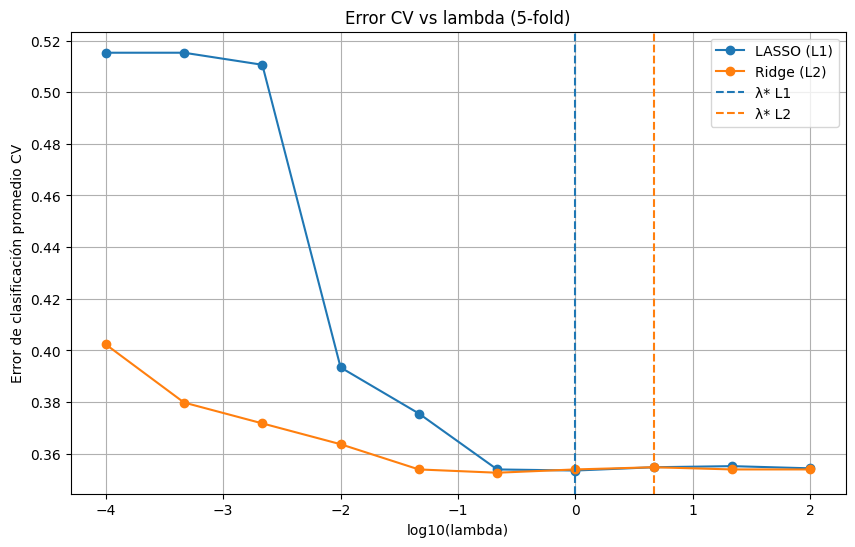

In [ ]:
# =========================================================
# ERROR DE CLASIFICACIÓN PROMEDIO EN CV
# =========================================================

Cs = resultados_modelos['lambdas']
err_l2 = 1 - lr_cv_l2.scores_[1].mean(axis=0)
err_l1 = 1 - lr_cv_l1.scores_[1].mean(axis=0)
n_vals = np.log10(Cs)

plt.figure(figsize=(10, 6))
plt.plot(n_vals, err_l1, marker='o', label='LASSO (L1)')
plt.plot(n_vals, err_l2, marker='o', label='Ridge (L2)')

plt.axvline(np.log10(resultados_modelos['lambda_opt_l1']), color='C0', linestyle='--', label='λ* L1')
plt.axvline(np.log10(resultados_modelos['lambda_opt_l2']), color='C1', linestyle='--', label='λ* L2')

plt.xlabel('log10(lambda)')
plt.ylabel('Error de clasificación promedio CV')
plt.title('Error CV vs lambda (5-fold)')
plt.grid(True)
plt.legend()
plt.show()


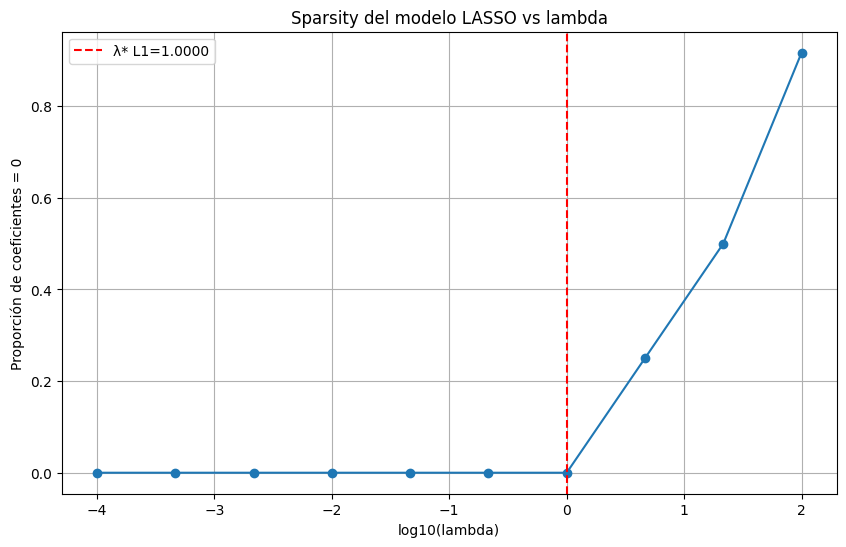

In [ ]:
# =========================================================
# SPARSITY EN LASSO: % DE VARIABLES EN CERO
# =========================================================

prop_zero = (coefs_l1 == 0).mean(axis=1)  # proporción por lambda

plt.figure(figsize=(10, 6))
plt.plot(n_vals, prop_zero, marker='o')
plt.axvline(np.log10(lambda_opt_l1), color='r', linestyle='--',
            label=f'λ* L1={lambda_opt_l1:.4f}')

plt.xlabel('log10(lambda)')
plt.ylabel('Proporción de coeficientes = 0')
plt.title('Sparsity del modelo LASSO vs lambda')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# =========================================================
# TABLA DE COEFICIENTES: SIN PENALIDAD vs L1 vs L2
# =========================================================

coef_none = resultados_modelos['none'].coef_.ravel()
coef_l1_cv = resultados_modelos['l1'].coef_.ravel()
coef_l2_cv = resultados_modelos['l2'].coef_.ravel()

tabla_coef = pd.DataFrame({
    'Variable': X_train.columns,
    'Logit_sin_penalidad': coef_none,
    'LASSO_L1': coef_l1_cv,
    'Ridge_L2': coef_l2_cv
})

# Orden por valor absoluto del coeficiente sin penalidad (más interpretativo)
tabla_coef['abs'] = tabla_coef['Logit_sin_penalidad'].abs()
tabla_coef = tabla_coef.sort_values(by='abs', ascending=False).drop(columns='abs')

print(tabla_coef)


                                 Variable  Logit_sin_penalidad  LASSO_L1  \
11  AEDUC_cat_Superior_completo_Postgrado            -1.518191 -1.512861   
7             AEDUC_cat_Primaria_completa             0.736556  0.666004   
8         AEDUC_cat_Secundaria_incompleta             0.725944  0.656206   
6           AEDUC_cat_Primaria_incompleta             0.623145  0.552583   
1                             CH06_scaled            -0.536889 -0.534499   
9           AEDUC_cat_Secundaria_completa             0.415506  0.353836   
5                                   Viudo            -0.332432 -0.273680   
2                      HORASTRAB_fulltime            -0.294094 -0.278665   
4                      SeparadoDivorciado             0.134654  0.097704   
10          AEDUC_cat_Superior_incompleto            -0.124790 -0.165808   
0                                    CH04             0.025181  0.017547   
3                                  Casado            -0.022509 -0.010069   

    Ridge_L

In [ ]:
# =========================================================
# MODELO ÁRBOL DE DECISIÓN
# =========================================================

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cost-complexity pruning path
dt = DecisionTreeClassifier(random_state=0)
path = dt.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas = np.unique(path.ccp_alphas)

# Reducir a 50 alphas si hay demasiados
if len(ccp_alphas) > 50:
    ccp_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 50)

# Evaluar con cross-validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=0)
mean_errors, std_errors = [], []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha,
                                 max_depth=4, min_samples_leaf=20)
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=kf10,
                             scoring='accuracy', n_jobs=-1)
    mean_errors.append(1 - scores.mean())
    std_errors.append(scores.std())

mean_errors = np.array(mean_errors)
std_errors = np.array(std_errors)
best_idx = np.argmin(mean_errors)
best_alpha = ccp_alphas[best_idx]

# Modelo final
clf_final = DecisionTreeClassifier(
    random_state=0, ccp_alpha=best_alpha,
    max_depth=4, min_samples_leaf=20
)
clf_final.fit(X_train_scaled, y_train)

# Guardar resultados en un diccionario
resultados_arbol = {
    'model': clf_final,
    'best_alpha': best_alpha,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'feature_importances': clf_final.feature_importances_
}

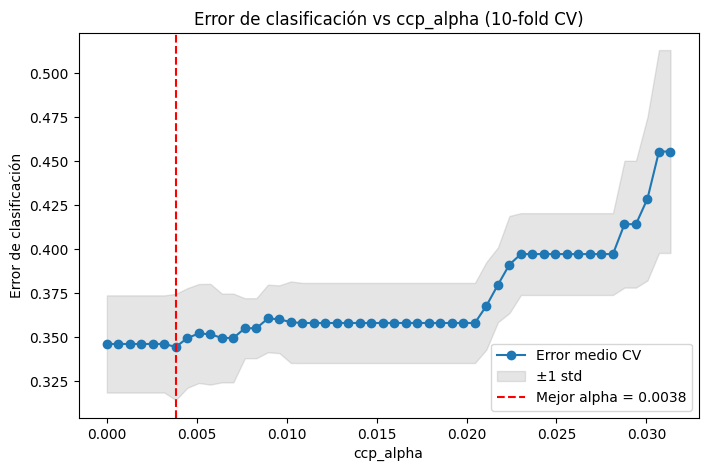

El mejor ccp_alpha según CV es 0.0038, que minimiza el error de clasificación.
Se observa cómo el error disminuye inicialmente y luego aumenta si el alpha es demasiado grande, lo que indica sobre-poda.


In [ ]:
# =========================================================
# MODELO ÁRBOL DE DECISIÓN CON PODADO Y CV
# =========================================================


# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cost-complexity pruning path
dt = DecisionTreeClassifier(random_state=0)
path = dt.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas = np.unique(path.ccp_alphas)

# Reducir a 50 alphas si hay demasiados
if len(ccp_alphas) > 50:
    ccp_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 50)

# Evaluar con 10-fold cross-validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=0)
mean_errors, std_errors = [], []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha,
                                 max_depth=4, min_samples_leaf=20)
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=kf10,
                             scoring='accuracy', n_jobs=-1)
    mean_errors.append(1 - scores.mean())  # error de clasificación
    std_errors.append(scores.std())

mean_errors = np.array(mean_errors)
std_errors = np.array(std_errors)
best_idx = np.argmin(mean_errors)
best_alpha = ccp_alphas[best_idx]

# Gráfico de error vs ccp_alpha
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, mean_errors, marker='o', label='Error medio CV')
plt.fill_between(ccp_alphas, mean_errors - std_errors, mean_errors + std_errors,
                 color='gray', alpha=0.2, label='±1 std')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Mejor alpha = {best_alpha:.4f}')
plt.xlabel('ccp_alpha')
plt.ylabel('Error de clasificación')
plt.title('Error de clasificación vs ccp_alpha (10-fold CV)')
plt.legend()
plt.show()

# Modelo final con el mejor alpha
clf_final = DecisionTreeClassifier(
    random_state=0, ccp_alpha=best_alpha,
    max_depth=4, min_samples_leaf=20
)
clf_final.fit(X_train_scaled, y_train)

# Guardar resultados en un diccionario
resultados_arbol = {
    'model': clf_final,
    'best_alpha': best_alpha,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'feature_importances': clf_final.feature_importances_
}

# Comentario sobre los resultados
print(f"El mejor ccp_alpha según CV es {best_alpha:.4f}, que minimiza el error de clasificación.")
print("Se observa cómo el error disminuye inicialmente y luego aumenta si el alpha es demasiado grande, lo que indica sobre-poda.")


In [ ]:
# =========================================================
# MODELO KNN
# =========================================================

# Definir rango de vecinos a evaluar
param_grid = {'n_neighbors': list(range(3, 22, 2))}

# Inicializar KNN
knn = KNeighborsClassifier()

# Búsqueda de hiperparámetros con cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo KNN
knn_mejor = grid_search.best_estimator_

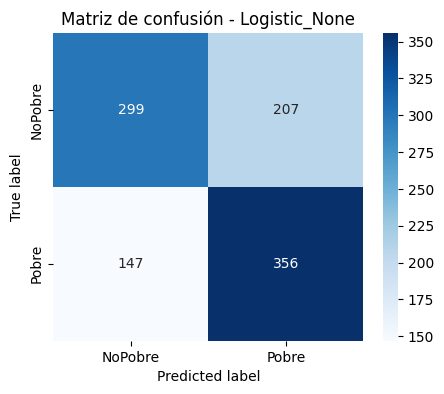

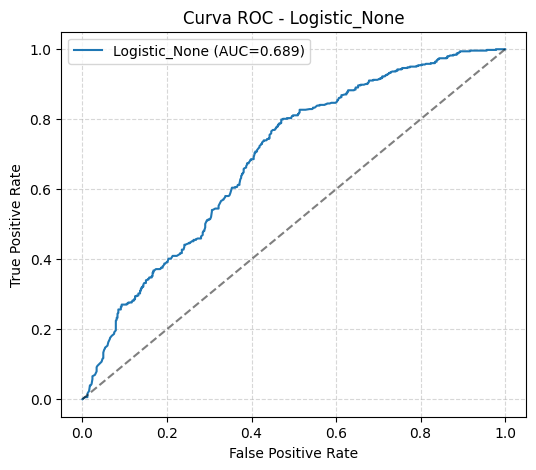


--- Logistic_None ---
Accuracy: 0.6492 (1 - accuracy = 0.3508)
F1-score: 0.6679
AUC: 0.6892


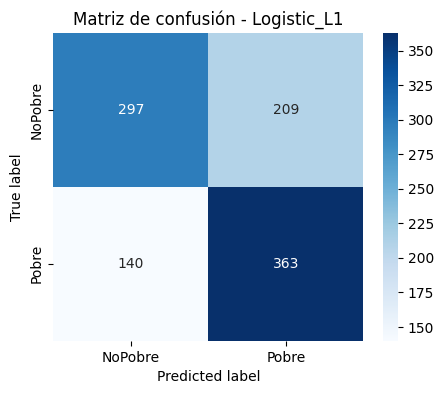

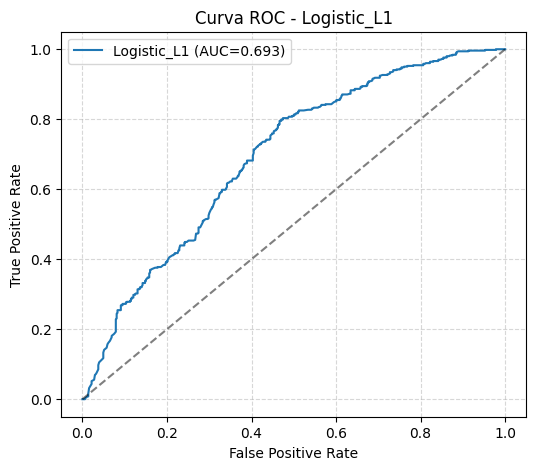


--- Logistic_L1 ---
Accuracy: 0.6541 (1 - accuracy = 0.3459)
F1-score: 0.6753
AUC: 0.6932


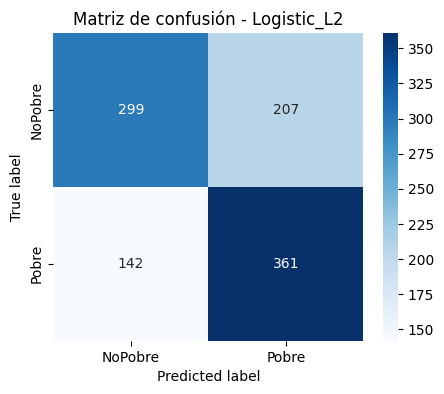

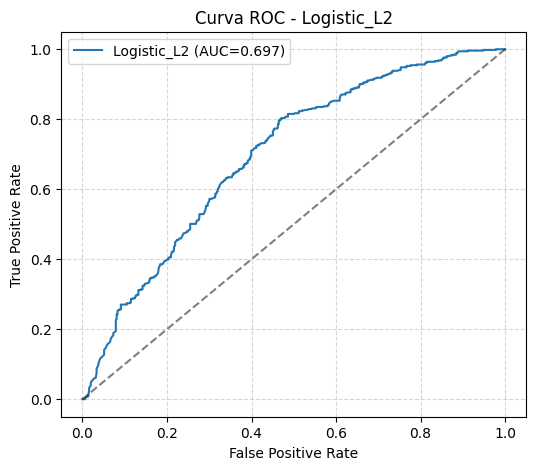


--- Logistic_L2 ---
Accuracy: 0.6541 (1 - accuracy = 0.3459)
F1-score: 0.6741
AUC: 0.6975


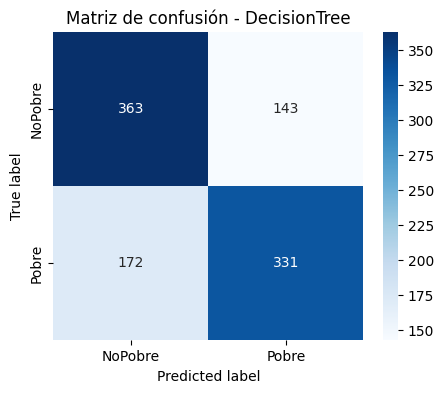

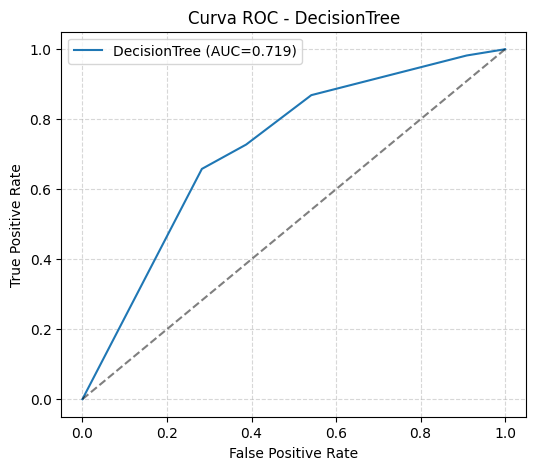


--- DecisionTree ---
Accuracy: 0.6878 (1 - accuracy = 0.3122)
F1-score: 0.6776
AUC: 0.7189


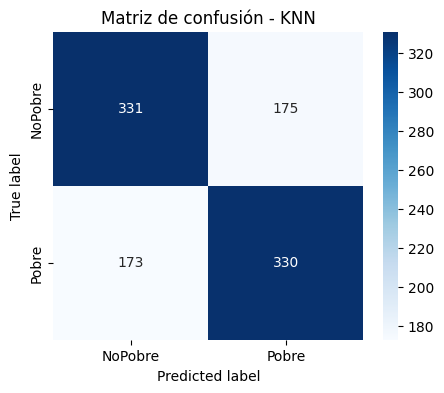

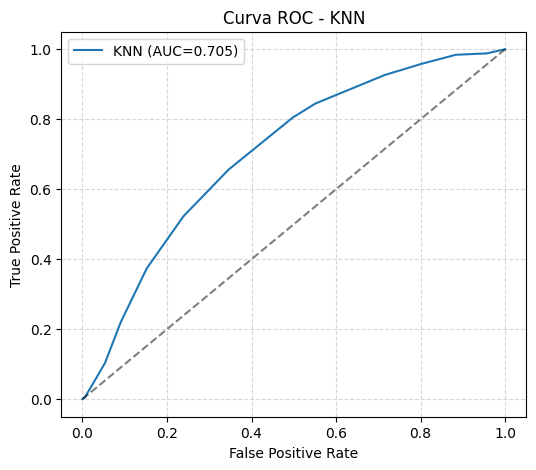


--- KNN ---
Accuracy: 0.6551 (1 - accuracy = 0.3449)
F1-score: 0.6548
AUC: 0.7052

Comparación de modelos:
                accuracy  1-accuracy        f1  precision    recall       auc
name                                                                        
Logistic_None  0.649158    0.350842  0.667917   0.632327  0.707753  0.689197
Logistic_L1    0.654113    0.345887  0.675349   0.634615  0.721670  0.693189
Logistic_L2    0.654113    0.345887  0.674136   0.635563  0.717694  0.697499
DecisionTree   0.687810    0.312190  0.677584   0.698312  0.658052  0.718880
KNN            0.655104    0.344896  0.654762   0.653465  0.656064  0.705227


In [ ]:
# =========================================================
# EVALUACIÓN DE MODELOS
# =========================================================

# Lista de modelos a evaluar
models = {
    'Logistic_None': resultados_modelos['none'],
    'Logistic_L1': resultados_modelos['l1'],
    'Logistic_L2': resultados_modelos['l2'],
    'DecisionTree': resultados_arbol['model'],
    'KNN': knn_mejor
}

results = []

for name, model in models.items():
    # Obtener probabilidades o scores según modelo
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]  # DecisionTree y KNN
    else:
        y_proba = model.decision_function(X_test_scaled)    # regresión logística sin predict_proba

    # Predicción binaria usando threshold 0.5
    y_pred = (y_proba > 0.5).astype(int)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NoPobre','Pobre'], yticklabels=['NoPobre','Pobre'])
    plt.title(f'Matriz de confusión - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.3f})')
    plt.plot([0,1], [0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics = {
        'name': name,
        'accuracy': acc,
        '1-accuracy': 1-acc,  # para trade-off
        'f1': f1,
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'fpr': fpr,
        'tpr': tpr
    }

    # Mostrar métricas
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f} (1 - accuracy = {1-acc:.4f})")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    results.append(metrics)

# Crear DataFrame comparativo
df_results = pd.DataFrame(results).set_index('name')[['accuracy','1-accuracy','f1','precision','recall','auc']]
print("\nComparación de modelos:\n", df_results)


In [ ]:
# =========================================================
# TABLA RESUMEN MATRIZ DE CONFUSIÓN Y MÉTRICAS
# =========================================================

# Lista de modelos a evaluar
models = {
    'Logistic_None': resultados_modelos['none'],
    'Logistic_L1': resultados_modelos['l1'],
    'Logistic_L2': resultados_modelos['l2'],
    'DecisionTree': resultados_arbol['model'],
    'KNN': knn_mejor
}

# Crear lista para guardar resultados
summary = []

for name, model in models.items():
    # Obtener probabilidades o scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.decision_function(X_test_scaled)

    # Predicción binaria con threshold 0.5
    y_pred = (y_proba > 0.5).astype(int)

    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    one_minus_acc = 1 - acc

    summary.append({
        'Modelo': name,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
        'Accuracy': acc,
        '1-Accuracy': one_minus_acc,
        'F1-score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc
    })

# Crear DataFrame final
df_summary = pd.DataFrame(summary)
df_summary = df_summary.set_index('Modelo')

# Mostrar tabla
pd.set_option('display.float_format', '{:.3f}'.format)
print(df_summary)


                TN   FP   FN   TP  Accuracy  1-Accuracy  F1-score  Precision  \
Modelo                                                                         
Logistic_None  299  207  147  356     0.649       0.351     0.668      0.632   
Logistic_L1    297  209  140  363     0.654       0.346     0.675      0.635   
Logistic_L2    299  207  142  361     0.654       0.346     0.674      0.636   
DecisionTree   363  143  172  331     0.688       0.312     0.678      0.698   
KNN            331  175  173  330     0.655       0.345     0.655      0.653   

               Recall   AUC  
Modelo                       
Logistic_None   0.708 0.689  
Logistic_L1     0.722 0.693  
Logistic_L2     0.718 0.697  
DecisionTree    0.658 0.719  
KNN             0.656 0.705  


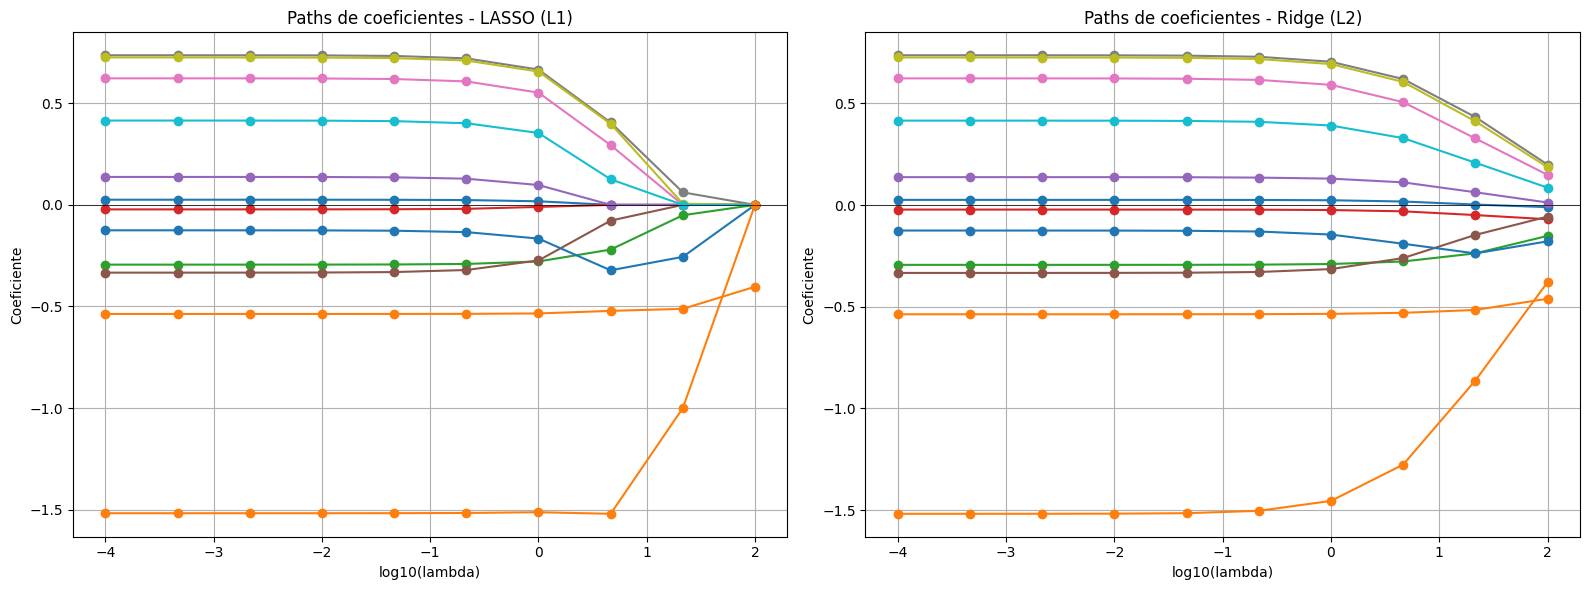

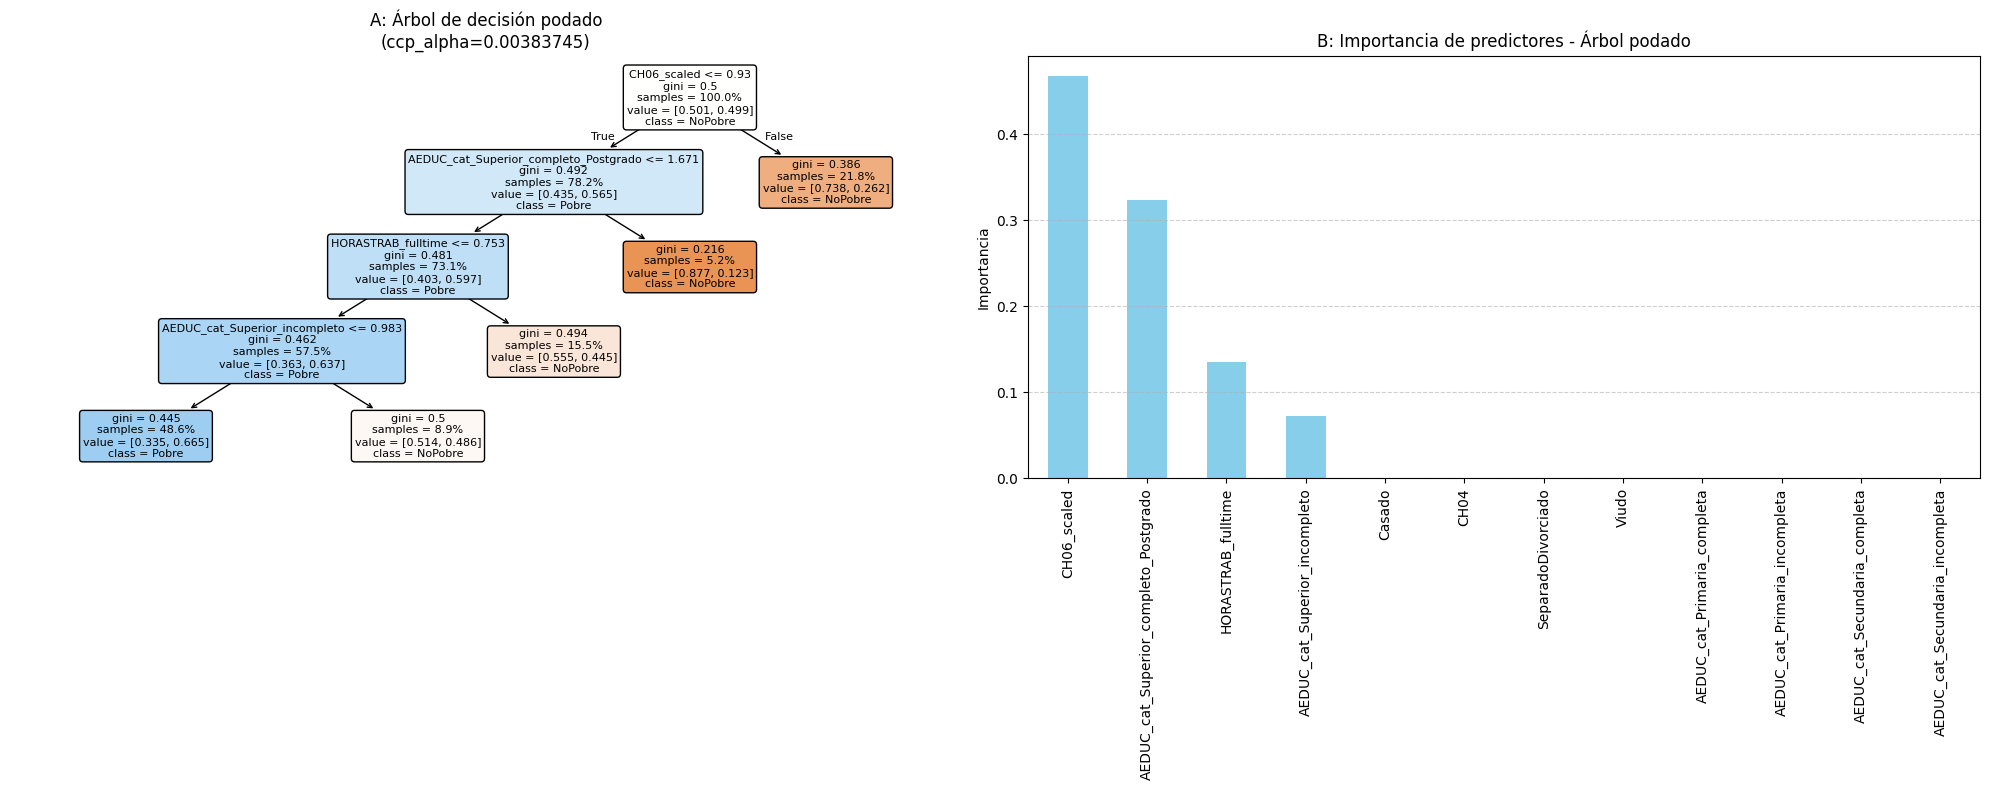

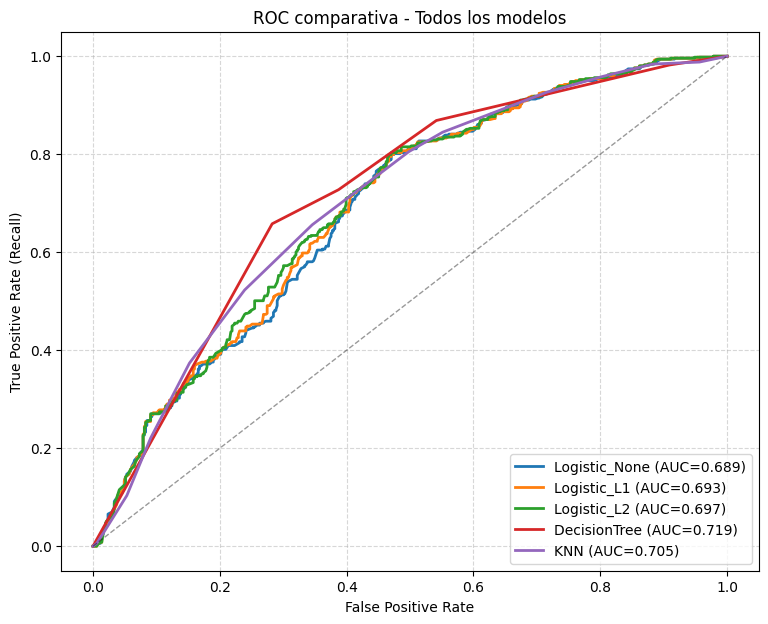

In [ ]:
# =========================================================
# VISUALIZACIONES
# =========================================================

# Definir nombres de variables usadas en los modelos
feature_names = X_train.columns.tolist()

# 1. Regresión logística
# Paths de coeficientes regresión logística
coefs_l1 = resultados_modelos['coefs_l1']
coefs_l2 = resultados_modelos['coefs_l2']
lambdas = resultados_modelos['lambdas']
n_vals = np.log10(lambdas)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# L1 (LASSO)
for j in range(coefs_l1.shape[1]):
    axes[0].plot(n_vals, coefs_l1[:, j], marker='o', label=feature_names[j])
axes[0].set_xlabel('log10(lambda)')
axes[0].set_ylabel('Coeficiente')
axes[0].set_title('Paths de coeficientes - LASSO (L1)')
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].grid(True)

# L2 (Ridge)
for j in range(coefs_l2.shape[1]):
    axes[1].plot(n_vals, coefs_l2[:, j], marker='o', label=feature_names[j])
axes[1].set_xlabel('log10(lambda)')
axes[1].set_ylabel('Coeficiente')
axes[1].set_title('Paths de coeficientes - Ridge (L2)')
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].grid(True)

plt.tight_layout()
plt.show()


# 2. Árbol de decisión + Importancia de variables en panel AB
if resultados_arbol and 'model' in resultados_arbol:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # A. Árbol de decisión podado
    from sklearn.tree import plot_tree
    plot_tree(resultados_arbol['model'], feature_names=feature_names,
              class_names=['NoPobre','Pobre'], filled=True, proportion=True,
              rounded=True, fontsize=8, ax=axes[0])
    axes[0].set_title(f"A: Árbol de decisión podado\n(ccp_alpha={resultados_arbol['best_alpha']:.6g})")

    # B. Importancia de variables
    if 'feature_importances' in resultados_arbol:
        importances = resultados_arbol['feature_importances']
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', ax=axes[1], color='skyblue')
        axes[1].set_ylabel('Importancia')
        axes[1].set_title('B: Importancia de predictores - Árbol podado')
        axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


# 3. ROC comparativa de todos los modelos
plt.figure(figsize=(9, 7))
colors = plt.cm.tab10.colors

for i, result in enumerate(results):
    plt.plot(result['fpr'], result['tpr'], color=colors[i % 10], lw=2,
             label=f"{result['name']} (AUC={result['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC comparativa - Todos los modelos")
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
